In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torchvision
import torch.nn as nn
import torchgeometry as tgm
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import torch.nn.functional as F
import numpy as np
from ConvWass2D import ConvolutionalWasserstein2D
from utils import d, make_K_slow, make_K, multiply_reshape

In [2]:
def show_image(inp):
    inp = inp / torch.max(inp.view(3, -1), dim=-1).values.view(3, 1, 1)
    inp = torchvision.transforms.ToPILImage()(inp)
    plt.imshow(inp) #[0,...])
    plt.show()

In [3]:
def transform(inp):
    inp = torchvision.transforms.ToTensor()(inp)
    inp = inp + 1e-4
    inp = inp / torch.sum(torch.abs(inp))
    return torch.cat([inp, inp, inp], 0)

In [4]:
MNIST_DIR = "/mnt/home/hlawrence/ceph/datasets" #"/data/theory/robustopt/saachij/dataset_dumps/mnist"

In [5]:
ds = torchvision.datasets.MNIST(MNIST_DIR,
                                train=True, download=False, transform=transform)
dl = torch.utils.data.DataLoader(ds, batch_size=32)
for x, y in dl:
    break

inp torch.Size([2, 3, 28, 28])


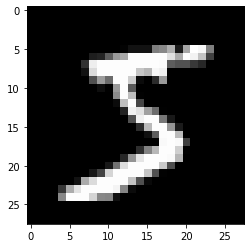

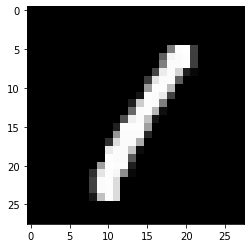

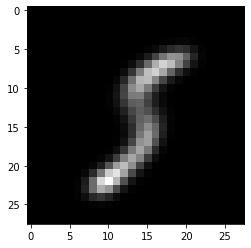

Barycenter objective value:  tensor(1.6156)


In [6]:
# example conv_was
cw = ConvolutionalWasserstein2D(3, 28, gamma=2)
with torch.no_grad():
    inp = x[[0, 3]]
    print('inp', inp.shape)
    alphas = torch.tensor([0.5, 0.5])
    facs = [0.3] #[5,6,7,8,9,10]
    for fac in facs:
        out = cw.wass_barycenter(inp, alphas, 10, entropic_args={'factor':fac})
        show_image(inp[0, ...])
        show_image(inp[1, ...])
        show_image(out)

objval = cw.wass_barycenter_obj(out, inp, alphas)
print('Barycenter objective value: ',objval[0])

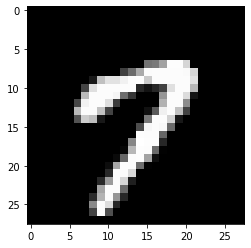

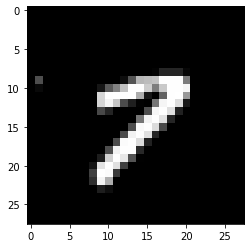

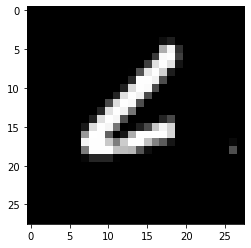

Comparison of Wasserstein barycenter objective, for different rotations
Correct: tensor(0.3056) Rot. 90:  tensor(0.4490) Rot. 180:  tensor(0.3866) Rot. 270:  tensor(0.4243)


In [7]:
# Is Wasserstein distance a good alignment metric? Test this first without doing any fancy rotations
# Consider two sevens: asymmetric
# print(torch.where(y == 7))
seven1 = x[15, ...]
seven2 = x[29, ...]
show_image(x[15, ...])
show_image(x[29, ...]) # note: this one is small enough that can probably rotate continuously??
show_image(seven2.flip(-1).flip(-2))
objvals=cw.sinkhorn(seven1, seven2, iters=10)
objvals90=cw.sinkhorn(seven1, torch.rot90(seven2, k=1, dims=[1,2]), iters=10)
objvals180=cw.sinkhorn(seven1, seven2.flip(-1).flip(-2), iters=10)
objvals270=cw.sinkhorn(seven1, torch.rot90(seven2, k=-1, dims=[1,2]), iters=10)
print('Comparison of Wasserstein barycenter objective, for different rotations')
print('Correct:', objvals[0, 0], 'Rot. 90: ', objvals90[0, 0], 'Rot. 180: ', objvals180[0, 0], 'Rot. 270: ', objvals270[0, 0])

In [9]:
H = cw.H
gamma = 2
gs = 29

matched_points = torch.tensor([[[6, 20], [9, 18]], [[26,9], [22,9]]])
matched_points.shape

K, C, C_keypoints = make_K(2, 0.0001, 5, matched_points)


torch.Size([2, 2, 2])

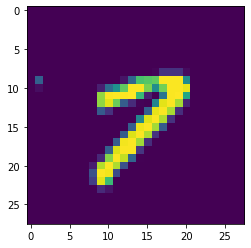

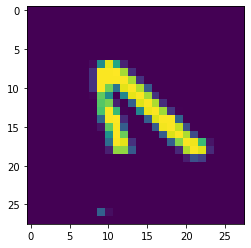

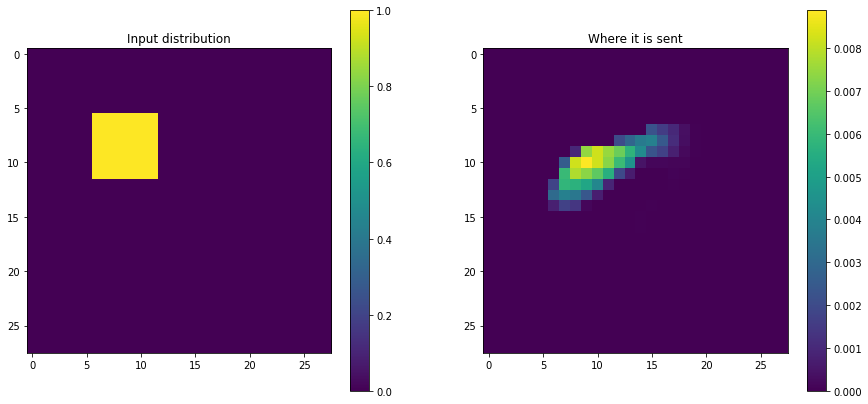

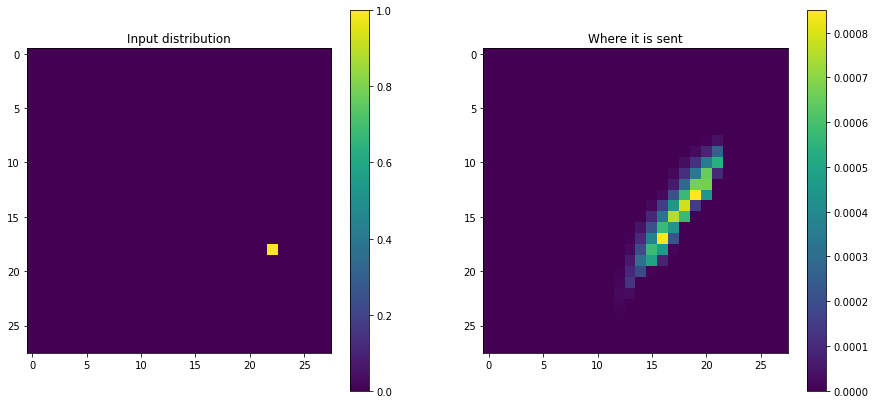

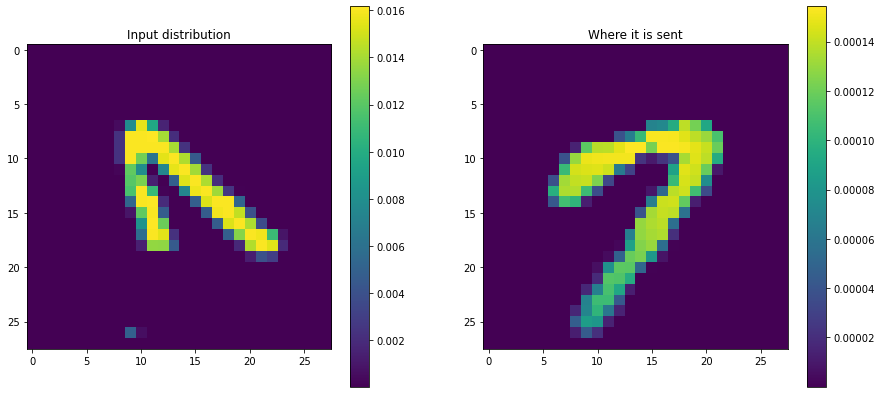

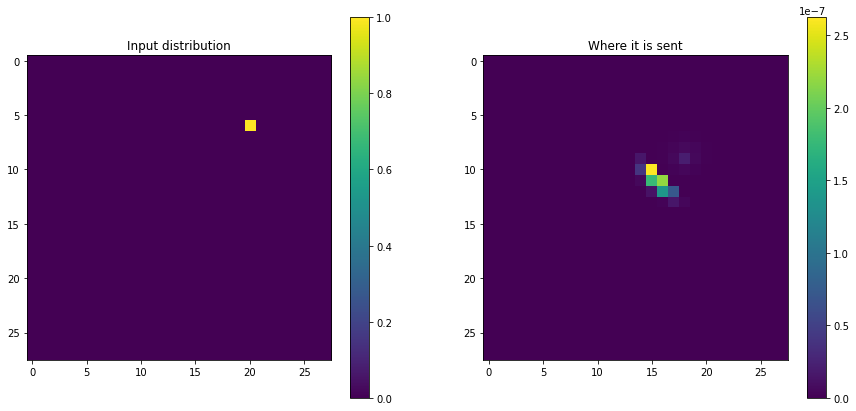

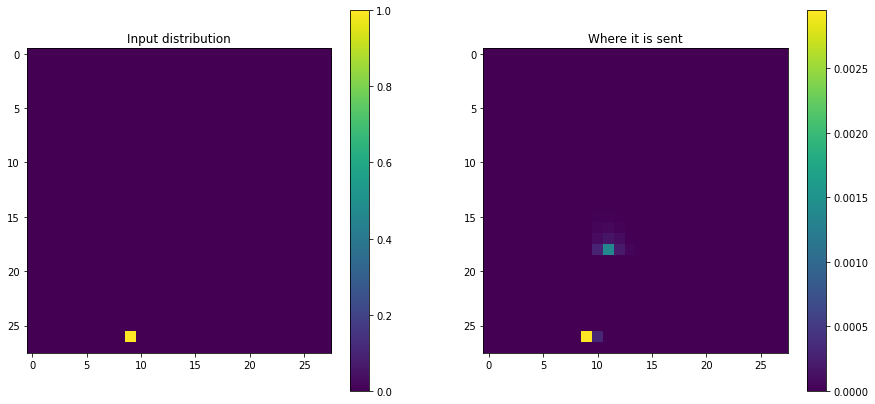

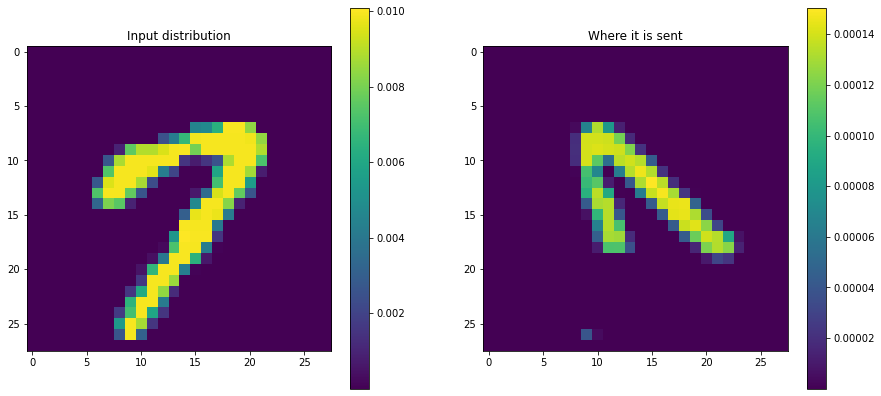

In [11]:
seven1 = x[15, ...]
seven2 = x[29, ...]
matched_points = torch.tensor([[[6, 20], [9, 18]], [[26,9], [22,9]]])

seven2rotated = torch.rot90(seven2, k=1, dims=[1,2])
plt.imshow(seven2[0,...])
plt.show()
plt.imshow(seven2rotated[0,...])
plt.show()

dorot = 1
if dorot:
    seven2 = seven2rotated
    check_rot_keypoints = 0
    if check_rot_keypoints:
        msk = torch.zeros(seven2.shape)
        msk[:,matched_points[1][1][0], matched_points[1][1][1]] = 1
        print('NZ', torch.nonzero(msk).shape, torch.nonzero(msk), 'DONE')
        mskrotated = torch.rot90(msk, k=1, dims=[1,2])
        print('NZ', torch.nonzero(mskrotated).shape, torch.nonzero(mskrotated), 'DONE')
    
    matched_points = torch.tensor([[[6, 20], [9, 9]], [[26,9], [18, 22]]]) # [6, 10]]]) #, [[26,9], [18, 22]]])
    
alpha = 5
gamma = 2
K = torch.exp(-1 * (C + alpha*C_keypoints) / (2* gamma**2))

customH = lambda x:multiply_reshape(K, x)
customHT = lambda x:multiply_reshape(K.permute(2,3,0,1),x)

CWkeypts = ConvolutionalWasserstein2D(3, 28, gamma=2, customH=customH, customHT=customHT) 
kpobjvals, kpv, kpw=CWkeypts.sinkhorn(seven1, seven2, iters=10, return_plan=True)
plan = lambda x: kpv*CWkeypts.H(kpw*x)
planT = lambda x: kpw*CWkeypts.HT(kpv*x)

testmask1=torch.zeros(CWkeypts.a.shape)
testmask1[0,:,matched_points[0][0][0],matched_points[0][0][1]] = 1
testmask2=torch.zeros(CWkeypts.a.shape)
testmask2[0,:,matched_points[1][0][0], matched_points[1][0][1]] = 1

testmask3=torch.zeros(CWkeypts.a.shape)
testmask3[0,:,matched_points[0][1][0],matched_points[0][1][1]] = 1

testmask3=torch.zeros(CWkeypts.a.shape)
testmask3[0,:,matched_points[0][1][0]-3 : matched_points[0][1][0]+3, matched_points[0][1][1] - 3: matched_points[0][1][1] + 3] = 1

testmask4=torch.zeros(CWkeypts.a.shape)
testmask4[0,:,matched_points[1][1][0], matched_points[1][1][1]] = 1


CWkeypts.visualize_plan(plan, input_dist=testmask3) # or can use self.a # or is testmask3 better???? can check later...
CWkeypts.visualize_plan(plan, input_dist=testmask4) # or can use self.a
CWkeypts.visualize_plan(plan, input_dist=seven2.unsqueeze(0)) # or can use self.a

CWkeypts.visualize_plan(planT, input_dist=testmask1)
CWkeypts.visualize_plan(planT, input_dist=testmask2)
CWkeypts.visualize_plan(planT, input_dist=seven1.unsqueeze(0))



inp torch.Size([2, 3, 28, 28])
no keypoints


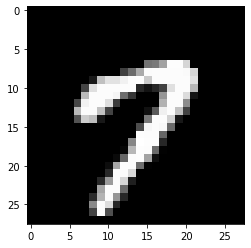

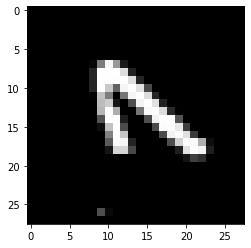

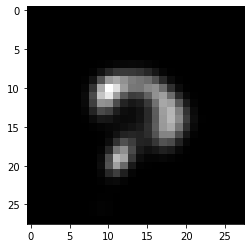

wrong use of keypoints
inp torch.Size([2, 3, 28, 28])


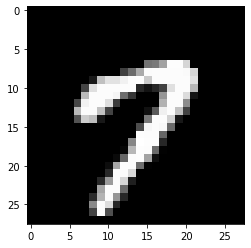

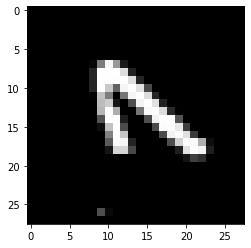

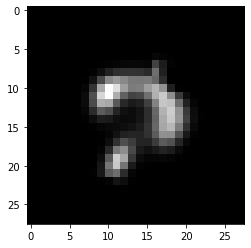

shape torch.Size([2, 1, 2])
tentative use of keypoints?
inp torch.Size([2, 3, 28, 28])


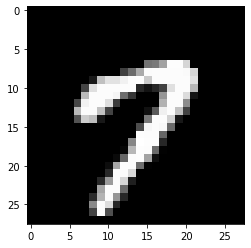

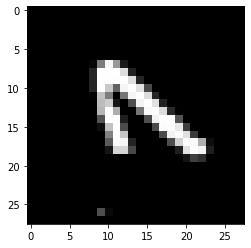

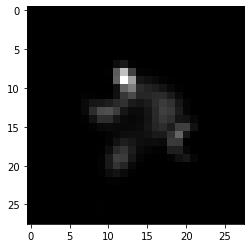

In [51]:
alpha = 5
gamma = 2
    
# Check barycenter, without any keypoints
CWbary_normal = ConvolutionalWasserstein2D(3, 28, gamma=2) #, customH=H_for_barycenters, customHT=HT_for_barycenters)
with torch.no_grad():
    inp = torch.stack((seven1, seven2), dim=0)
    print('inp', inp.shape)
    alphas = torch.tensor([0.5, 0.5])
    facs = [0.3] #[5,6,7,8,9,10]
    print('no keypoints')
    for fac in facs:
        out = CWbary_normal.wass_barycenter(inp, alphas, 10, entropic_args={'factor':fac})
        show_image(inp[0, ...])
        show_image(inp[1, ...])
        show_image(out)
        
    
# Check barycenter, "normal" although not really b/c of H's
print('wrong use of keypoints')
with torch.no_grad():
    inp = torch.stack((seven1, seven2), dim=0)
    print('inp', inp.shape)
    alphas = torch.tensor([0.5, 0.5])
    facs = [0.3] #[5,6,7,8,9,10]
    for fac in facs:
        out = CWkeypts.wass_barycenter(inp, alphas, 10, entropic_args={'factor':fac})
        show_image(inp[0, ...])
        show_image(inp[1, ...])
        show_image(out)
        

# Barycenter with keypoints, less naively??
keypoints1 = matched_points[:, 0:1, :]
keypoints2 = matched_points[:, 1:2, :]
base_keypoints = keypoints2
print('shape', keypoints1.shape)
torch.cat((base_keypoints, keypoints1), dim=1)
_, C1, C_keypoints1 = make_K(2, 0.0001, 5, torch.cat((base_keypoints, keypoints1), dim=1))
K1 = torch.exp(-1 * (C1 + alpha*C_keypoints1) / (2* gamma**2))

_, C2, C_keypoints2 = make_K(2, 0.0001, 5, torch.cat((base_keypoints, keypoints2), dim=1))
K2 = torch.exp(-1 * (C2 + alpha*C_keypoints2) / (2* gamma**2))

bigK = torch.stack((K1, K2), dim=0)
bigKT = bigK.permute(0, 3, 4, 1, 2)

def H_for_barycenters(vec):
    num_batch = vec.shape[0]
    return torch.matmul(bigK.reshape(num_batch,1,784, 784).repeat(1,3,1,1),vec.reshape(num_batch,3,-1, 1)).reshape(num_batch,3,28,28)

def HT_for_barycenters(vec):
    num_batch = vec.shape[0]
    return torch.matmul(bigKT.reshape(num_batch,1, 784, 784).repeat(1,3,1,1),vec.reshape(num_batch,3,-1, 1)).reshape(num_batch,3,28,28)

CWbary = ConvolutionalWasserstein2D(3, 28, gamma=2, customH=H_for_barycenters, customHT=HT_for_barycenters)
print('tentative use of keypoints?')
with torch.no_grad():
    inp = torch.stack((seven1, seven2), dim=0)
    print('inp', inp.shape)
    alphas = torch.tensor([0.5, 0.5])
    facs = [0.3] #[5,6,7,8,9,10]
    for fac in facs:
        out = CWbary.wass_barycenter(inp, alphas, 10, entropic_args={'factor':fac})
        show_image(inp[0, ...])
        show_image(inp[1, ...])
        show_image(out)
        


tensor([[[ 6, 20],
         [ 9,  9]],

        [[26,  9],
         [18, 22]]])


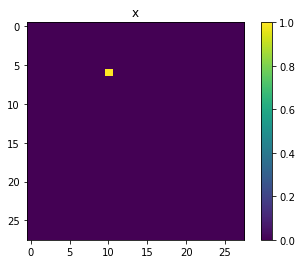

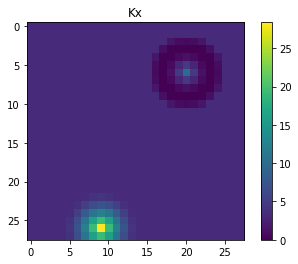

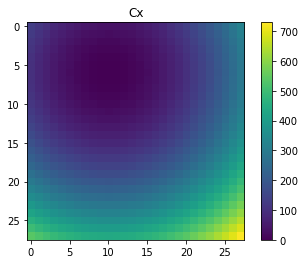

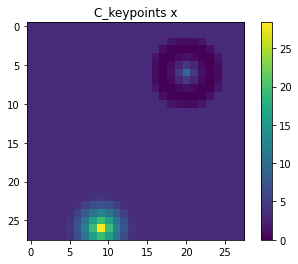

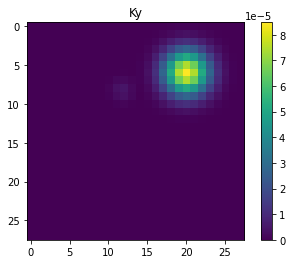

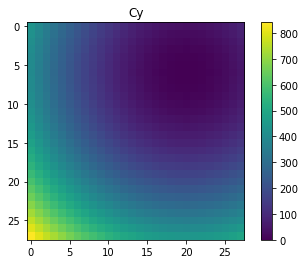

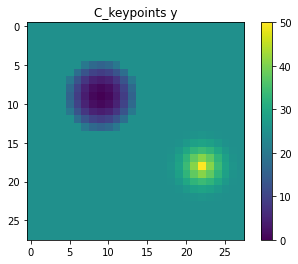

In [17]:
# CHECK THE COST MATRICES
# torch.tensor([[[6, 20], [6, 10]]])
print(matched_points)
K, C, C_keypoints = make_K(2, 0.0001, 5, matched_points)
C=C.float()
xx = torch.zeros(1,3,28,28)
xx[:,:,6,10] = 1
#xx[:,:,0,0] = 1
plt.imshow(xx[0,0,...])
plt.colorbar()
plt.title('x')
plt.show()

alpha = 3
gamma = 2
K = torch.exp(-1 * (C + alpha*C_keypoints) / (2* gamma**2))

temp=multiply_reshape(C_keypoints,xx) #multiply_reshape(K,xx)
plt.imshow(temp[0,0,...])
plt.colorbar()
plt.title('Ckp x')
plt.show()

temp=multiply_reshape(C,xx)
plt.imshow(temp[0,0,...])
plt.colorbar()
plt.title('Cx')
plt.show()

temp=multiply_reshape(C_keypoints,xx)
plt.imshow(temp[0,0,...])
plt.colorbar()
plt.title('C_keypoints x')
plt.show()

yy = torch.zeros(1,3,28,28)
yy[:,:,6,20] = 1

temp=multiply_reshape(K.permute(2,3,0,1),yy)
plt.imshow(temp[0,0,...])
plt.colorbar()
plt.title('Ky')
plt.show()

temp=multiply_reshape(C.permute(2,3,0,1),yy)
plt.imshow(temp[0,0,...])
plt.colorbar()
plt.title('Cy')
plt.show()

temp=multiply_reshape(C_keypoints.permute(2,3,0,1),yy)
plt.imshow(temp[0,0,...])
plt.colorbar()
plt.title('C_keypoints y')
plt.show()
    
    

In [ ]:
# From stack overflow https://stackoverflow.com/questions/64197754/how-do-i-rotate-a-pytorch-image-tensor-around-its-center-in-a-way-that-supports
def get_rot_mat(theta):
    theta = torch.tensor(theta)
    return torch.tensor([[torch.cos(theta), -torch.sin(theta), 0],
                         [torch.sin(theta), torch.cos(theta), 0]])

def rot_img(x, theta, dtype):
    rot_mat = get_rot_mat(theta)[None, ...].type(dtype).repeat(x.shape[0],1,1)
    grid = F.affine_grid(rot_mat, x.size()).type(dtype)
    x = F.grid_sample(x, grid)
    return x

def rot_and_renorm(img, theta):
    # img is B x C x H x W
    B, C, H, W = img.shape
    out = rot_img(img, theta, img.dtype)
    # fill in values, under assumption that upper left corner is representative
    out[out < 1e-8] = img[0, 0, 0, 0]
    out = out / (torch.sum(out, dim=[-1, -2]).view(B, C, 1, 1).repeat(1, 1, H, W))
    return out

def wrap_around_angle(angles1, angles2):
    # either both scalars, or both of length B
    # between 0 and 2*pi
    diffs = torch.abs(torch.tensor(angles1 - angles2))
    dists = torch.min(diffs, torch.remainder(-1*diffs, 2*np.pi))
    return dists
    
out=rot_img(seven1.float().view(1, 3,28,28), 0.5*(np.pi/2), seven1.float().dtype)

In [ ]:
# L2 vs W2 distance for particular examples (7s and 5s) of image pairs
numtheta = 100
iters = 10
thetas = 2*np.pi*np.linspace(0,1,numtheta); thetas = thetas[0:-1]
#print(torch.where(y == 8))
seven1 = x[15, ...] # 15 for 7, 5 for 2
seven2 = x[29, ...] # 29 for 7, 19 for 9, 16 for 2
eight1 = x[17, ...] # 17 for 8
eight2 = x[31, ...] # 31 for 8
sevens_W2 = torch.zeros(len(thetas))
eights_W2 = torch.zeros(len(thetas))
sevens_L2 = torch.zeros(len(thetas))
eights_L2 = torch.zeros(len(thetas))
for ind, theta in enumerate(thetas):
    roteight2 = rot_and_renorm(eight2.unsqueeze(0), theta)
    rotseven2 = rot_and_renorm(seven2.unsqueeze(0), theta)
    eights_W2[ind] = cw.sinkhorn(eight1, roteight2, iters=iters)[0, 0]
    sevens_W2[ind] = cw.sinkhorn(seven1, rotseven2, iters=iters)[0, 0]
    eights_L2[ind] = torch.norm(eight1 - roteight2)
    sevens_L2[ind] = torch.norm(seven1 - rotseven2)

print('Eights')
plt.figure()
plt.subplot(121)
plt.imshow(eight1[0,...])
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.subplot(122)
plt.imshow(eight2[0,...])
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(thetas / (2*np.pi) * 360, eights_W2,'o-')
plt.xlabel('Rotation (degrees)')
plt.title('Wasserstein')
plt.subplot(122)
plt.plot(thetas / (2*np.pi) * 360, eights_L2,'o-')
plt.title(r'$L_2$')
plt.xlabel('Rotation (degrees)')
plt.suptitle('Eights')
plt.show()

print('Sevens')
plt.figure()
plt.subplot(121)
plt.imshow(seven1[0,...])
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.subplot(122)
plt.imshow(seven2[0,...])
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(thetas / (2*np.pi) * 360, sevens_W2,'o-')
plt.title('Wasserstein')
plt.xlabel('Rotation (degrees)')
plt.subplot(122)
plt.plot(thetas / (2*np.pi) * 360, sevens_L2,'o-')
plt.title(r'$L_2$')
plt.xlabel('Rotation (degrees)')
plt.suptitle('Sevens')
plt.show()
    
print('Eight, W2 err:', wrap_around_angle(thetas[torch.argmin(eights_W2)], 0))
print('Eight, L2 err:', wrap_around_angle(thetas[torch.argmin(eights_L2)], 0))
print('Seven, W2 err:', wrap_around_angle(thetas[torch.argmin(sevens_W2)], 0))
print('Seven, L2 err:', wrap_around_angle(thetas[torch.argmin(sevens_L2)], 0))

In [ ]:
optsevenrotW2 = thetas[torch.argmin(sevens_W2)]
rotseven2 = rot_and_renorm(seven2.unsqueeze(0), optsevenrotW2)
plt.subplot(121)
plt.imshow(seven1[0,...])
plt.subplot(122)
plt.imshow(seven2[0,...]) #rotseven2[0,0,...])
plt.show()

In [ ]:
# Next figure: rotated vs unrotated barycenters
ops = [False, True]
for do_rot in ops:
    if do_rot:
        print('Unaligned Barycenters')
    else:
        print('Aligned Barycenters')
    im1 = x[3, ...]
    im2 = x[0, ...]
    
    im1 = seven1
    im2 = seven2
    if do_rot:
        im2 = rot_and_renorm(im2.unsqueeze(0), np.pi * 0.4)[0, ...]
    numalpha = 7
    alphas = np.linspace(0, 1, numalpha) # barycenter code isn't batched in alpha, have to loop it for now
    plt.figure(figsize=(15, 10))
    for ind, alpha in enumerate(alphas):
        plt.subplot(1, numalpha, ind+1)
        out = cw.wass_barycenter(torch.stack((im1, im2), dim=0), torch.tensor([alpha, 1-alpha]), 10, entropic_args={'factor':0.3})
        plt.imshow(out[0,...])
        plt.title(r'$\alpha = ${:.2f}'.format(alpha))
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
    plt.tight_layout()
    #plt.savefig('BarycentersAligned' + str(do_rot) + '.jpg')
    plt.show()
    